<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Principal Component Analysis (PCA) </center></h2>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate Toy Sample

Let's generate a simple toy sample and will use it to consider how PCA works.

In [2]:
from sklearn import datasets

# Generate 2D Gaussian distribution
n_samples = 1000
X, y = datasets.make_blobs(n_samples=n_samples, random_state=42, centers=[[0, 0]])

# Apply coordiantes transformation
transformation = [[0.6, 0.4], 
                  [0.4, 0.6]]
X = np.dot(X, transformation)

In [3]:
X

array([[ 0.8514483 ,  0.76514118],
       [ 0.81391703,  0.39024593],
       [-0.8906364 , -0.53221298],
       ...,
       [ 0.41873993,  0.64692725],
       [-1.13484131, -1.21643359],
       [ 0.73859928,  0.31811284]])

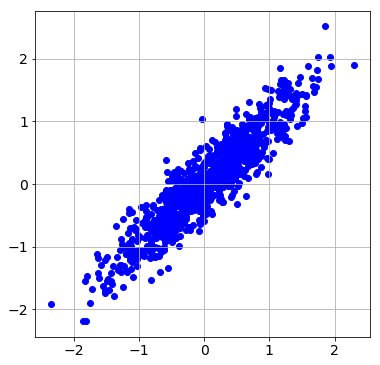

In [4]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], color='b')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(b=1)
plt.show()

# Principal Component Analysis (PCA)


Find directions along which our datapoints have the greatest variance:


<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/05/correlated_2d.png' width=400></center>


These directions are principal components. Principal components $a_{1},a_{2},...a_{D}\in\mathbb{R}^{D}$ are orthonormal: 

$$
\langle a_{i},a_{j}\rangle=\begin{cases}
1, & i=j\\
0 & i\ne j
\end{cases}
$$

## PCA algorithm (detailed):
(Following your lectures)

### Step 1:
Calculate variance across a principal component $a$ assuming that $X$ is centralized:
$$
\begin{align} \sigma^2_a & = \frac{1}{n}\sum\limits_{i=1}^n(a^\top x_i - \mu)^2 \\
& = \frac{1}{n}\sum\limits_{i=1}^n(a^\top x_i - 0)^2 \\
& = \frac{1}{n}\sum\limits_{i=1}^n a^\top( x_i x_i^\top) a \\
& = a^\top \left(\frac{1}{n}\sum\limits_{i=1}^n x_i x_i^\top \right) a \\
& = a^\top X^\top X a \\
\end{align}
$$

### Step 2:
Find $a_1$ that maximizes the variance:

$$
\begin{equation}
\begin{cases}
a_1^\top X^\top X a_1 \rightarrow \max_{a_1} \\
a_1^\top a_1 = 1
\end{cases}
\end{equation}
$$

Lagrangian of optimization problem:
$$ \mathcal{L}(a_1, \nu) = a_1^\top X^\top X a_1 - \nu (a_1^\top a_1 - 1) \rightarrow max_{a_1, \nu}$$

Derivative w.r.t. $a_1$:
$$ \frac{\partial\mathcal{L}}{\partial a_1} = 2X^\top X a_1 - 2\nu a_1 = 0 $$

$$X^\top X a_1 = \nu a_1$$

---
#### Note:
So $a_1$ is selected from a set of eigenvectors of  $X^\top X$. But which one?

$$ a_1^\top X^\top X a_1 = \nu a_1^\top a_1 = \nu \rightarrow \max$$

That means:
* $\nu$ should be the greatest eigenvalue of matrix $X^\top X$, which is $\lambda_1$
* $a_1$ is eigenvector, correspondent to $\lambda_1$
---

### Step 3:

Similarly for $a_{2}$:

$$
\begin{equation}
\begin{cases}
a_2^\top X^\top X a_2 \rightarrow \max_{a_2} \\
a_2^\top a_2 = 1 \\
a_2^\top a_1 = 0
\end{cases}
\end{equation}
$$

...

## PCA algorithm (short)

1. Center (and scale) dataset
2. Calculate covariance matrix $С=X^\top X$
3. Find first $k$ eigenvalues and eigenvectors
$$A = 
\left[
  \begin{array}{cccc}
    \mid & \mid & & \mid\\
    a_{1} & a_{2} & \ldots & a_{k} \\
    \mid & \mid & & \mid 
  \end{array}
\right]
$$
4. Perform projection:
$$ Z = XA $$ 

In [5]:
class MyPCA(object):
    
    def __init__(self, n_components=1):
        """
        This class performs PCA.
        
        Parameters
        ----------
        n_components : int
            Number of the first principle components to use.
        """
        
        self.n_components = n_components
        self.means = None
        self.stds = None
        self.A = None
        self.eig_vals = None
        self.eig_vecs = None
        
        
    def _normalize(self, X, is_fit=True):
        """
        This method centers and scales input data.
        
        Parameters
        ----------
        X : numpy.ndarray
            Input data sample with shape=[n_objects, n_features]
            
        Returns
        -------
        X_center : numpy.ndarray
            Centered and scaled input data sample with shape=[n_objects, n_features]
        """
        if is_fit:
            self.means = X.mean(axis=0)
            self.stds = X.std(axis=0)
            
        X_center = ( X - self.means ) / self.stds
        
        return X_center
        
    
    def fit(self, X):
        """
        This method searches for the first eigenvectors for PCA.
        
        Parameters
        ----------
        X : numpy.ndarray
            Input data smaple with shape=[n_objects, n_features]
        """
        
        # Centering (and scaling)
        X_center = self._normalize(X)
        
        # Calculate covariance matrix
        C = np.dot(X_center.T, X_center)
        
        # Find eigenvalues and eigenvectors
        self.eig_vals, self.eig_vecs = np.linalg.eig(C)
        
        # Sort eigenvalues
        sorted_indeces = self.eig_vals.argsort()[::-1]
        
        # Take the first n_components
        if self.n_components > len(self.eig_vecs):
            print("Are you crazy?! You want more components that I have. I'll give only ", str(len(self.eig_vecs)))
        n_first_indeces = sorted_indeces[:self.n_components]
        self.A = self.eig_vecs[n_first_indeces].T
        
        
    def transform(self, X):
        """
        Performs projections on the selected components.
        
        Parameters
        ----------
        X : numpy.ndarray
            Input data smaple with shape=[n_objects, n_features]
            
        Returns
        -------
        X_pca : numpy.ndarray
            Transformed input data smaple with shape=[n_objects, n_components]
        """
        
        if self.A is None:
            print("Hey! What are you doing? Fit me firstly.")
            return X
        
        # Centering (and scaling)
        X_center = self._normalize(X, is_fit=False)
            
        # Perform projection
        X_pca = np.dot(X_center, self.A)
        
        return X_pca

Apply our PCA on the sample:

In [6]:
pca = MyPCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [7]:
X_pca

array([[ 0.10593947,  1.51411034],
       [ 0.4361439 ,  1.10872446],
       [-0.36612117, -1.50351778],
       ...,
       [-0.21147927,  0.96474142],
       [ 0.06054932, -2.4193718 ],
       [ 0.43147381,  0.96252043]])

In [8]:
pca_1 = MyPCA(n_components=1)
pca_1.fit(X)
X_pca_1 = pca_1.transform(X)

pca_2 = MyPCA(n_components=2)
pca_2.fit(X)
X_pca_2 = pca_2.transform(X)

No handles with labels found to put in legend.


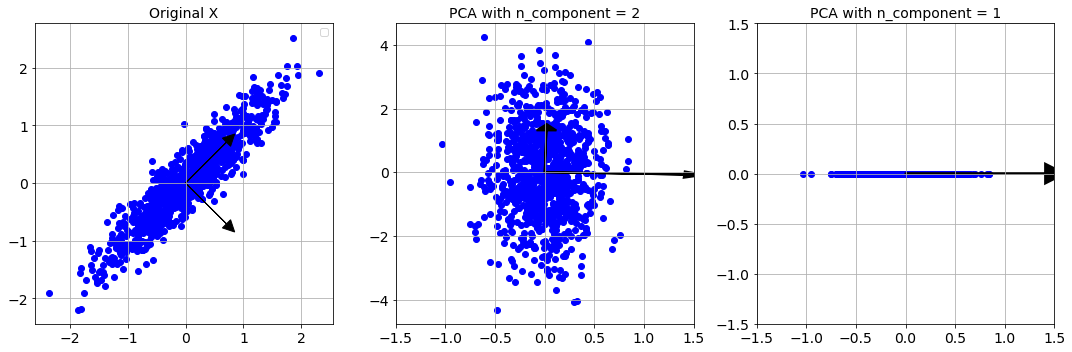

In [9]:
plt.figure(figsize=(15, 5))

# Plot original X with eigenvectors
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], color='b')
for vector in pca_2.eig_vecs:
    plt.arrow(0, 0, vector[0], vector[1], head_width=0.2, head_length=0.2, fc='k', ec='k')
plt.title("Original X", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(b=1)
plt.legend(loc='best')


# Plot for PCA with n_components=2
plt.subplot(1, 3, 2)
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], color='b')
for vector in pca_2.transform(pca_2.eig_vecs):
    plt.arrow(0, 0, vector[0], vector[1], head_width=0.2, head_length=0.2, fc='k', ec='k', linewidth=2)
plt.title("PCA with n_component = 2", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-1.5, 1.5)
plt.grid(b=1)


# Plot for PCA with n_components=1
plt.subplot(1, 3, 3)
plt.scatter(X_pca_1[:, 0], [0]*len(X_pca_1), color='b')
for vector in pca_1.transform(pca_1.eig_vecs):
    if vector[0] <= 0.5: continue
    plt.arrow(0, 0, vector[0], 0, head_width=0.2, head_length=0.2, fc='k', ec='k', linewidth=2)
plt.title("PCA with n_component = 1", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(b=1)


plt.tight_layout()
plt.show()

# Statlog (Vehicle Silhouettes) Data Set
https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29

The purpose is to classify a given silhouette as one of four types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles. 

Attribute Information:

ATTRIBUTES: <br>

COMPACTNESS	(average perim)^2/area <br>
CIRCULARITY	(average radius)^2/area <br>
DISTANCE CIRCULARITY	area/(av.distance from border)^2 <br>
RADIUS RATIO	(max.rad-min.rad)/av.radius <br>
PR.AXIS ASPECT RATIO	(minor axis)/(major axis) <br>
MAX.LENGTH ASPECT RATIO	(length perp. max length)/(max length) <br>
SCATTER RATIO	(inertia about minor axis)/(inertia about major axis) <br>
ELONGATEDNESS	area/(shrink width)^2 <br>
PR.AXIS RECTANGULARITY	area/(pr.axis length*pr.axis width) <br>
MAX.LENGTH RECTANGULARITY area/(max.length*length perp. to this) <br>
SCALED VARIANCE (2nd order moment about minor axis)/area <br>
ALONG MAJOR AXIS <br>
SCALED VARIANCE (2nd order moment about major axis)/area <br>
ALONG MINOR AXIS <br>
SCALED RADIUS OF GYRATION	(mavar+mivar)/area <br>
SKEWNESS ABOUT (3rd order moment about major axis)/sigma_min^3 <br>
MAJOR AXIS <br>
SKEWNESS ABOUT (3rd order moment about minor axis)/sigma_maj^3 <br>
MINOR AXIS <br>
KURTOSIS ABOUT (4th order moment about major axis)/sigma_min^4 
MINOR AXIS <br>
KURTOSIS ABOUT (4th order moment about minor axis)/sigma_maj^4 
MAJOR AXIS <br>
HOLLOWS RATIO	(area of hollows)/(area of bounding polygon) <br>

Where sigma_maj^2 is the variance along the major axis and sigma_min^2 is the variance along the minor axis, and 
area of hollows= area of bounding poly-area of object 

The area of the bounding polygon is found as a side result of the computation to find the maximum length. Each individual length computation yields a pair of calipers to the object orientated at every 5 degrees. The object is propagated into an image containing the union of these calipers to obtain an image of the bounding polygon. 

NUMBER OF CLASSES:  OPEL, SAAB, BUS, VAN

In [10]:
# Read data sample
data = pd.read_csv("data/vehicle.csv")
print("DataFrame shape: ", data.shape)
data.head()

DataFrame shape:  (846, 19)


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


## Data Preparation

In [11]:
from sklearn.preprocessing import LabelEncoder

# Select two classes
data = data[(data['class'] == 'bus') + (data['class'] == 'saab')]

# Take feature names
features = data.columns.drop("class")

# Prepare X and y for classification
X = data[features].values
y = 1. * (data["class"].values == 'saab')

In [12]:
X[:5]

array([[104,  50, 106, 209,  66,  10, 207,  32,  23, 158, 223, 635, 220,
         73,  14,   9, 188, 196],
       [ 85,  44,  70, 205, 103,  52, 149,  45,  19, 144, 241, 325, 188,
        127,   9,  11, 180, 183],
       [107,  57, 106, 172,  50,   6, 255,  26,  28, 169, 280, 957, 264,
         85,   5,   9, 181, 183],
       [ 97,  43,  73, 173,  65,   6, 153,  42,  19, 143, 176, 361, 172,
         66,  13,   1, 200, 204],
       [ 93,  44,  98, 197,  62,  11, 183,  36,  22, 146, 202, 505, 152,
         64,   4,  14, 195, 204]])

In [13]:
y[:5]

array([1., 0., 0., 0., 1.])

## Train / Test Split + Standardization

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Standardization
ss = StandardScaler()
ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Train Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
#clf = LogisticRegression()
clf = KNeighborsClassifier(n_neighbors=5)
#clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
y_test_predict = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_test, y_test_predict)
auc = roc_auc_score(y_test, y_test_proba)
print("Accuracy: ", accuracy)
print("ROC AUC: ", auc)

Accuracy:  0.9036697247706422
ROC AUC:  0.9739412309505768


## Apply PCA

In [18]:
pca_accuracies = []
pca_aucs = []
pca_components = np.arange(1, 19)

for n_components in pca_components:
    
    # For each n_components run PCA
    pca = MyPCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Fit a classifier
    #clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
    #clf = RandomForestClassifier(n_estimators=100)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train_pca, y_train)
    
    # Make predictions
    y_test_predict = clf.predict(X_test_pca)
    y_test_proba = clf.predict_proba(X_test_pca)[:, 1]
    
    # Calculate quality metrics
    accuracy = accuracy_score(y_test, y_test_predict)
    pca_accuracies.append(accuracy)
    
    auc = roc_auc_score(y_test, y_test_proba)
    pca_aucs.append(auc)

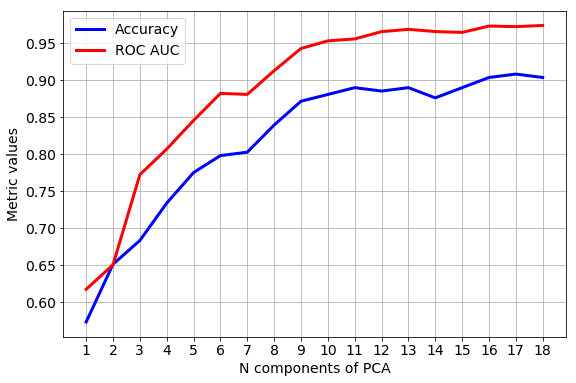

In [19]:
plt.figure(figsize=(9, 6))
plt.plot(pca_components, pca_accuracies, label='Accuracy', color='b', linewidth=3)
plt.plot(pca_components, pca_aucs, label='ROC AUC', color='r', linewidth=3)
plt.xticks(pca_components, size=14)
plt.xlabel("N components of PCA", size=14)
plt.yticks(size=14)
plt.ylabel("Metric values", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

## Explained variance

Explained variance for $a_i$ can be calculated as the following ratio:
$$
\frac{\lambda_{i}}{\sum_{d=1}^{D}\lambda_{d}}
$$

In [20]:
# Fit PCA
pca = MyPCA(n_components=9)
pca.fit(X_train)

# Take all eigenvalues
eigenvalues = pca.eig_vals

# Sort eigenvalues
eigenvalues = np.sort(eigenvalues)[::-1]

In [21]:
eigenvalues

array([2.02326324e+03, 7.06955366e+02, 4.18444800e+02, 2.61356690e+02,
       1.94453234e+02, 1.02899249e+02, 7.96948020e+01, 4.74626617e+01,
       2.59980608e+01, 1.59622449e+01, 8.95889404e+00, 6.75362140e+00,
       4.41752334e+00, 3.43681491e+00, 2.87878489e+00, 1.76723801e+00,
       1.24053844e+00, 5.62318013e-02])

In [22]:
pca_components = np.arange(1, 19)

# Calculate explained variance
explained_variance = eigenvalues / eigenvalues.sum()

# Calculate cumulative explained variance
cumsum_explained_variance = np.cumsum(explained_variance)

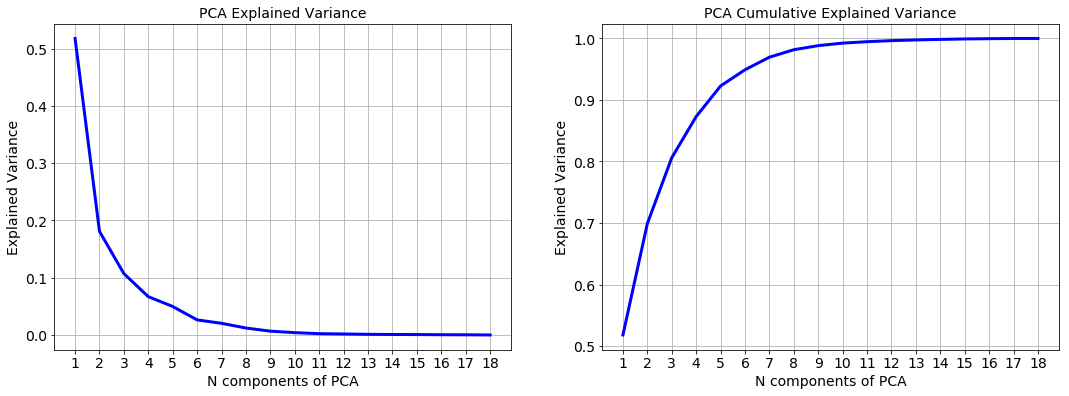

In [23]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(pca_components, explained_variance, color='b', linewidth=3)
plt.xticks(pca_components, size=14)
plt.xlabel("N components of PCA", size=14)
plt.yticks(size=14)
plt.ylabel("Explained Variance", size=14)
plt.title("PCA Explained Variance", size=14)
plt.grid(b=1)


plt.subplot(1, 2, 2)
plt.plot(pca_components, cumsum_explained_variance, color='b', linewidth=3)
plt.xticks(pca_components, size=14)
plt.xlabel("N components of PCA", size=14)
plt.yticks(size=14)
plt.ylabel("Explained Variance", size=14)
plt.title("PCA Cumulative Explained Variance", size=14)
plt.grid(b=1)


plt.show()